In [1]:
import os
import re
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Emotion mapping
EMO_MAP = {
    "ANG": 0,
    "DIS": 1,
    "FEA": 2,
    "HAP": 3,
    "NEU": 4,
    "SAD": 5
}
NUM_CLASSES = len(EMO_MAP)

# Data location
NPY_DIR = "mel_npy"


Device: cpu


In [3]:
npy_paths = sorted([str(p) for p in Path(NPY_DIR).glob("*.npy")])
print("Found NPY files:", len(npy_paths))


Found NPY files: 7431


In [4]:
example = np.load(npy_paths[0])
if example.ndim == 3:
    _, N_MELS, T_FRAMES = example.shape
else:
    N_MELS, T_FRAMES = example.shape

print("Spectrogram shape:", (1, N_MELS, T_FRAMES))


Spectrogram shape: (1, 128, 188)


In [5]:
def parse_actor_and_emotion(filename: str):

    # Actor ID = first number in filename
    actor_match = re.search(r"\d+", filename)
    if actor_match is None:
        raise ValueError(f"No actor ID in {filename}")
    actor_id = actor_match.group(0)

    # Emotion code
    emotion = None
    for emo in EMO_MAP:
        if f"_{emo}_" in filename or filename.startswith(f"{emo}_"):
            emotion = EMO_MAP[emo]
            break

    if emotion is None:
        raise ValueError(f"No emotion code in {filename}")

    return actor_id, emotion


In [6]:
def actor_independent_split(paths, train_ratio=0.7, val_ratio=0.15):
    by_actor = {}

    for p in paths:
        fname = os.path.basename(p)
        actor_id, _ = parse_actor_and_emotion(fname)
        by_actor.setdefault(actor_id, []).append(p)

    actors = list(by_actor.keys())
    random.shuffle(actors)

    n = len(actors)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_actors = set(actors[:n_train])
    val_actors   = set(actors[n_train:n_train+n_val])
    test_actors  = set(actors[n_train+n_val:])

    def collect(actor_set):
        out = []
        for a in actor_set:
            out.extend(by_actor[a])
        return out

    return (
        collect(train_actors),
        collect(val_actors),
        collect(test_actors)
    )


In [7]:
train_paths, val_paths, test_paths = actor_independent_split(npy_paths)
print(len(train_paths), len(val_paths), len(test_paths))


5141 1066 1224


In [8]:
class MelNPYDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        fname = os.path.basename(path)

        # loading spectrogram
        spec = np.load(path).astype(np.float32)
        if spec.ndim == 2:
            spec = spec[np.newaxis, :, :]

        # parsing label from filename
        _, label = parse_actor_and_emotion(fname)

        x = torch.from_numpy(spec)
        y = torch.tensor(label, dtype=torch.long)
        return x, y


In [9]:
BATCH_SIZE = 32

train_loader = DataLoader(
    MelNPYDataset(train_paths),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    MelNPYDataset(val_paths),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    MelNPYDataset(test_paths),
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [10]:
import torch

DEVICE = torch.device("cpu")
print("Using device:", DEVICE)


Using device: cpu


In [11]:
class CNNBiLSTM(nn.Module):
    def __init__(self, lstm_hidden=128):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,1))
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, N_MELS, T_FRAMES)
            z = self.cnn(dummy)
            C, Fp, Tp = z.shape[1], z.shape[2], z.shape[3]
            lstm_in = C * Fp

        self.lstm = nn.LSTM(
            input_size=lstm_in,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2*lstm_hidden, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, NUM_CLASSES)
        )

    def forward(self, x):
        z = self.cnn(x)                 # (B, C, F, T)
        z = z.permute(0, 3, 1, 2)       # (B, T, C, F)
        z = z.flatten(2)                # (B, T, C*F)
        out, _ = self.lstm(z)           # (B, T, 2H)

        # Better than out[:, -1] for emotion:
        out = out.mean(dim=1)           # (B, 2H)

        return self.fc(out)


In [12]:
from sklearn.metrics import accuracy_score, f1_score


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_true = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.append(preds)
        all_true.append(y.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    return acc, macro_f1


In [20]:
model = CNNBiLSTM(lstm_hidden=128).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)

# scheduler reduces LR when metric plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2, min_lr=1e-6
)

# training limits and early stopping settings
# early stopping will be triggered if there are no improvements for 8 epochs
max_epochs = 120
early_patience = 8
best_val = -1.0
wait = 0
best_path = "best_cremad.pt"

for epoch in range(1, max_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_f1 = evaluate(model, val_loader)

    target_metric = val_f1
    scheduler.step(target_metric)

    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f} | lr {lr:.2e}")

    if target_metric > best_val + 1e-4:
        best_val = target_metric
        wait = 0
        torch.save(model.state_dict(), best_path)
    else:
        wait += 1
        if wait >= early_patience:
            print(f"Early stopping. Best val_f1={best_val:.4f}")
            break

# loading best checkpoint
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
best_acc, best_f1 = evaluate(model, val_loader)
print(f"BEST CHECKPOINT | val_acc={best_acc:.4f} | val_macro_f1={best_f1:.4f}")


Epoch 001 | train_loss 1.5970 | val_acc 0.3587 | val_f1 0.3117 | lr 3.00e-04
Epoch 002 | train_loss 1.4722 | val_acc 0.4291 | val_f1 0.3599 | lr 3.00e-04
Epoch 003 | train_loss 1.4321 | val_acc 0.4451 | val_f1 0.4075 | lr 3.00e-04
Epoch 004 | train_loss 1.3891 | val_acc 0.4451 | val_f1 0.4140 | lr 3.00e-04
Epoch 005 | train_loss 1.3581 | val_acc 0.4638 | val_f1 0.4409 | lr 3.00e-04
Epoch 006 | train_loss 1.3101 | val_acc 0.4911 | val_f1 0.4736 | lr 3.00e-04
Epoch 007 | train_loss 1.2908 | val_acc 0.4995 | val_f1 0.4872 | lr 3.00e-04
Epoch 008 | train_loss 1.2468 | val_acc 0.5127 | val_f1 0.5015 | lr 3.00e-04
Epoch 009 | train_loss 1.2142 | val_acc 0.5099 | val_f1 0.5007 | lr 3.00e-04
Epoch 010 | train_loss 1.1779 | val_acc 0.5099 | val_f1 0.5005 | lr 3.00e-04
Epoch 011 | train_loss 1.1516 | val_acc 0.5446 | val_f1 0.5351 | lr 3.00e-04
Epoch 012 | train_loss 1.1129 | val_acc 0.5221 | val_f1 0.5179 | lr 3.00e-04
Epoch 013 | train_loss 1.0917 | val_acc 0.5587 | val_f1 0.5552 | lr 3.00e-04

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def get_preds(model, loader, device):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_p.append(preds)
        all_y.append(y.numpy())
    return np.concatenate(all_y), np.concatenate(all_p)

y_true, y_pred = get_preds(model, test_loader, DEVICE)

print(classification_report(y_true, y_pred, target_names=[k for k,v in sorted(EMO_MAP.items(), key=lambda x:x[1])]))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         ANG       0.71      0.75      0.73       208
         DIS       0.58      0.59      0.59       208
         FEA       0.60      0.52      0.56       207
         HAP       0.70      0.50      0.58       208
         NEU       0.66      0.73      0.69       178
         SAD       0.53      0.67      0.59       208

    accuracy                           0.62      1217
   macro avg       0.63      0.63      0.62      1217
weighted avg       0.63      0.62      0.62      1217

[[156  24   5  15   7   1]
 [ 19 122  10   4  18  35]
 [ 10  14 107  21   8  47]
 [ 30  17  36 104  14   7]
 [  3   6   2   3 130  34]
 [  2  26  17   2  21 140]]


In [22]:
FINAL_PATH = "cnn_bilstm_emotion.pt"

# model should already be the best one (or load best_path first)
torch.save(model.state_dict(), FINAL_PATH)
print("Saved weights to:", FINAL_PATH)


Saved weights to: cnn_bilstm_emotion.pt


In [13]:
model = CNNBiLSTM(lstm_hidden=128).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)

# scheduler reduces LR when metric plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2, min_lr=1e-6
)

# training limits and early stopping settings
# early stopping will be triggered if there are no improvements for 8 epochs
max_epochs = 120
early_patience = 8
best_val = -1.0
wait = 0
best_path = "best_cremad.pt"

for epoch in range(1, max_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_f1 = evaluate(model, val_loader)

    target_metric = val_f1
    scheduler.step(target_metric)

    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f} | lr {lr:.2e}")

    if target_metric > best_val + 1e-4:
        best_val = target_metric
        wait = 0
        torch.save(model.state_dict(), best_path)
    else:
        wait += 1
        if wait >= early_patience:
            print(f"Early stopping. Best val_f1={best_val:.4f}")
            break

# loading best checkpoint
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
best_acc, best_f1 = evaluate(model, val_loader)
print(f"BEST CHECKPOINT | val_acc={best_acc:.4f} | val_macro_f1={best_f1:.4f}")


Epoch 001 | train_loss 1.5895 | val_acc 0.3762 | val_f1 0.3049 | lr 3.00e-04
Epoch 002 | train_loss 1.4707 | val_acc 0.4250 | val_f1 0.3699 | lr 3.00e-04
Epoch 003 | train_loss 1.4368 | val_acc 0.4315 | val_f1 0.3764 | lr 3.00e-04
Epoch 004 | train_loss 1.3904 | val_acc 0.4418 | val_f1 0.3991 | lr 3.00e-04
Epoch 005 | train_loss 1.3641 | val_acc 0.4587 | val_f1 0.4291 | lr 3.00e-04
Epoch 006 | train_loss 1.3238 | val_acc 0.4690 | val_f1 0.4329 | lr 3.00e-04
Epoch 007 | train_loss 1.2788 | val_acc 0.4962 | val_f1 0.4725 | lr 3.00e-04
Epoch 008 | train_loss 1.2655 | val_acc 0.4897 | val_f1 0.4721 | lr 3.00e-04
Epoch 009 | train_loss 1.2193 | val_acc 0.5038 | val_f1 0.4966 | lr 3.00e-04
Epoch 010 | train_loss 1.1818 | val_acc 0.4841 | val_f1 0.4694 | lr 3.00e-04
Epoch 011 | train_loss 1.1507 | val_acc 0.5263 | val_f1 0.5232 | lr 3.00e-04
Epoch 012 | train_loss 1.1170 | val_acc 0.5356 | val_f1 0.5387 | lr 3.00e-04
Epoch 013 | train_loss 1.0952 | val_acc 0.5263 | val_f1 0.5210 | lr 3.00e-04

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def get_preds(model, loader, device):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_p.append(preds)
        all_y.append(y.numpy())
    return np.concatenate(all_y), np.concatenate(all_p)

y_true, y_pred = get_preds(model, test_loader, DEVICE)

print(classification_report(y_true, y_pred, target_names=[k for k,v in sorted(EMO_MAP.items(), key=lambda x:x[1])]))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         ANG       0.57      0.76      0.65       209
         DIS       0.56      0.51      0.54       209
         FEA       0.59      0.55      0.57       209
         HAP       0.58      0.66      0.61       209
         NEU       0.70      0.64      0.67       179
         SAD       0.66      0.52      0.58       209

    accuracy                           0.60      1224
   macro avg       0.61      0.61      0.60      1224
weighted avg       0.61      0.60      0.60      1224

[[158  21   6  20   3   1]
 [ 41 107  19  15   9  18]
 [ 14  16 114  34   9  22]
 [ 37  12  13 137   8   2]
 [ 16  11   7  18 115  12]
 [  9  23  34  13  21 109]]


In [15]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    cohen_kappa_score,
    log_loss,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)


Accuracy: 0.6045751633986928


In [17]:
uar = recall_score(y_true, y_pred, average='macro')
print("UAR (Macro Recall):", uar)


UAR (Macro Recall): 0.6054814537613714


In [18]:
macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro F1-score:", macro_f1)


Macro F1-score: 0.6039670703850984


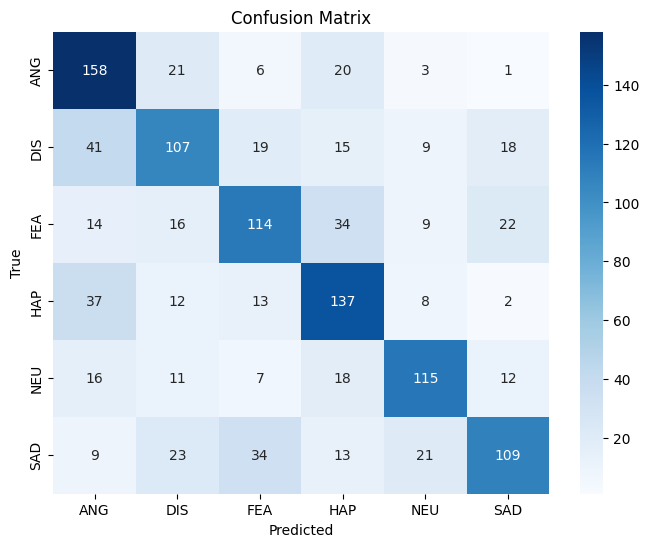

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[k for k, v in sorted(EMO_MAP.items(), key=lambda x: x[1])],
    yticklabels=[k for k, v in sorted(EMO_MAP.items(), key=lambda x: x[1])]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
